# Step 1:
***importing the libraries***

In [2]:
import numpy as np
import pandas as pd
import random
import os
import json
import sys
import gzip
from collections import defaultdict
import csv
import time

#nltk libraries and packages
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import wordnet as wn

#Ml related libraries
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as AUC





Using TensorFlow backend.


In [91]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Step 2:
***importing and reading the dataset as a pandas dataframe***

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz

In [ ]:
#reading the json file in a list

values=[]
with open("Electronics_5.json","r") as f:
    for i in f:
        values.append(json.loads(i))

        
print(values[:5])        

In [ ]:
##code to create the csv file by reading the json in batches of 1lkh rows

# total = len(values)

import csv

total = len(values)

batch = 100000

count = 0

for i in range(0,total,batch):
    print("iter number: ",count/batch)
    text = []
    overall = []
    revid = []
    time = []
    for j in range(count , count+batch):
        try:
            rtext = values[j]["reviewText"]
            rover = values[j]["overall"]
            rid = values[j]["reviewerID"]
            rtime = values[j]['unixReviewTime']
            
            text.append(rtext)
            overall.append(rover)
            revid.append(rid)
            time.append(rtime)
            
        except:
            pass
    count = count + batch
    with open("Electronic_review.csv" , "a",newline = "") as csvfile:
        xx = list(zip(revid , text , overall,time))
        writer = csv.writer(csvfile,delimiter = ",")
        for k in xx:
            writer.writerow(k)
            

In [ ]:
%reset_selective values

# Step 3:
***filtering out the data fields from the dataframe and storing the filtered data into another df***

In [ ]:
!pip install dask

In [ ]:
#read the dataset into a df
colnames = ["id","text","overall"]
df= pd.read_csv("Electronic_review.csv",names= colnames,header = None)


In [ ]:
#getting all the columns of the dataframe

print("HEAD:\n",df.head(5))
print("COLUMNS:\n",df.columns)
print("SHAPE:\n",df.shape)
print("NO. OF COLUMNS:\n",len(df.columns))

#finding the unique values assigned to the vote field in the dataset

print("UNIQUE VOTE VALUES:\n")
print(df['rating'].unique)                         #check the name of the column corresponding to vote


In [ ]:
pd.options.display.max_colwidth = 300

In [ ]:
print(df.loc[df['overall'] == 2.0]['text'][:2])

# Step 4:
***Populating the data with proper values of sentiments for applying supervised machine learning algorithms for sentiment analysis***

**The division of sentiment, on the basis of vote value, is as follows**

   * 0 < Vote < 3 => Negative sentiment (-1)
   * Vote = 3 => Neutral Sentiment (0)
   *  3 < Vote <= 5 => Positive Sentiment (1) 






In [ ]:
newdf = df
print(len(newdf))

In [ ]:
newdf.loc[1,'overall'] ==3

In [ ]:
#iterate over the complete dataset and populate the sentiment field
total = len(newdf)
batch = 100000
pr = 100
count=0
for i in range(0,total-1,batch):
    print("MAIN iteration is: ", count/batch)
    Sentiment = []
    for j in range(count,count+batch):
        if j%pr ==0:
            print("INTER iteration is: ", j/pr)
        vote_val = newdf.loc[count,"overall"]
        if vote_val == 3:
            Sentiment.append(0)
        elif vote_val>=0 and vote_val < 3:
            Sentiment.append(-1)
        else:
            Sentiment.append(1)
    print(len(Sentiment))
    print(count)
    print(count+batch)
    newdf.loc[count:count+batch-1,'Sentiment'] = Sentiment
    count = count+batch

In [ ]:
newdf.to_csv("processedData.csv",chunksize=100000)

# Step 5:
***preprocess the text data samples***

### Steps for preprocessing

  *  ***Filter out numbers***
  * ***Stemming and lemmitisation***
  * ***Remove stopwords***
  * ***Other root level token changes***





In [ ]:
!pip install nltk

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import wordnet as wn

import nltk
nltk.download("stopwords")

In [ ]:
%reset_selective df

In [ ]:
df= pd.read_csv("processedData.csv")

In [ ]:
import re

In [ ]:
nltk.download("punkt")

In [ ]:
df.head(5)

In [ ]:
# print(count)
df.loc[2099999,"review"]

In [ ]:
# df=newdf[:3000000]
# 21lkh  rows

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

#removing the blank rows if any
print("removing empty rows...")
df['review'].dropna(inplace=True)

#tokenise the data samples
print("tokenising reviews...")
total=len(df)
batch = 100000
count = 0
for i in range(0,total,batch):
    print("Iteration number:",count/batch)
    tokenised =[]
    for j in range(count,count+batch):
        tokenised.append(word_tokenize(df.loc[j,"review"]))
    df.loc[count:count+batch-1,"review"] = tokenised
    count = count+batch
        


In [ ]:
len(df.loc[10,"review"][:50])

In [ ]:
#using stemming instead of lemmitisation

from nltk.stem import PorterStemmer
ps = PorterStemmer() 

count = 0
for i in range(0,2100000,batch):
    print("Iteration number:",count/batch)
    fin = []
    for j in range(count,count+batch):
        if j%1000 ==0:
            print(j)
        Final_words = []
        if len(df.loc[j,"review"]) > 75:
            text = df.loc[j,"review"][:75]
        else:
            text = df.loc[j,"review"]
        for word in text:
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word = word.lower()
                word_Final = ps.stem(word)
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'reviewText_final'
        fin.append(str(Final_words))
    df.loc[coutn:count_batch-1,'reviewText_final'] = fin
    count+=batch



In [ ]:
df.head(5)

In [ ]:
%whos

In [ ]:
df.loc[count:count+batch-1,'reviewText_final'] = fin

In [ ]:
lat_df = df[:100000]

In [ ]:
lat_df.to_csv("CurrentUsedFile.csv")

In [ ]:
lat_df.head(5)

# Step 6:
## ***split the dataset into train and test set***

In [3]:
#importing thenew dataset
lat_df = pd.read_csv("CurrentUsedFile.csv")
print(lat_df.head(5))

   Unnamed: 0  Unnamed: 0.1              id  \
0           0             0   AAP7PPBU72QFM   
1           1             1  A2E168DTVGE6SV   
2           2             2  A1ER5AYS3FQ9O3   
3           3             3  A1T17LMQABMBN5   
4           4             4  A3QHJ0FXK33OBE   

                                              review  rating  Sentiment  \
0  ['This', 'is', 'the', 'best', 'novel', 'I', 'h...     5.0        1.0   
1  ['Pages', 'and', 'pages', 'of', 'introspection...     3.0        0.0   
2  ['This', 'is', 'the', 'kind', 'of', 'novel', '...     5.0        1.0   
3  ['What', 'gorgeous', 'language', '!', 'What', ...     5.0        1.0   
4  ['I', 'was', 'taken', 'in', 'by', 'reviews', '...     3.0        0.0   

                                    reviewText_final  
0  ['thi', 'best', 'novel', 'i', 'read', 'year', ...  
1  ['page', 'page', 'introspect', 'style', 'write...  
2  ['thi', 'kind', 'novel', 'read', 'time', 'lose...  
3  ['what', 'gorgeou', 'languag', 'what', 'inc

In [4]:
#create x and y => x:textreview , y:sentiment
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(lat_df['reviewText_final'],lat_df['Sentiment'],test_size=0.2,random_state = 42)

In [5]:
print(Train_X.shape,Train_Y.shape)
print(Test_X.shape,Test_Y.shape)

(80000,) (80000,)
(20000,) (20000,)


In [115]:
Test_Y_binarise = label_binarize(Test_Y,classes = [0,1,2])

# Step 7:
## ***Applying tfidf vectorisor to the tokens formed for each of the review sample***


In [6]:
# Encoder = LabelEncoder()
# Train_Y = Encoder.fit_transform(Train_Y)
# Test_Y = Encoder.fit_transform(Test_Y)

# Step - 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the df
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(max_features=500000)               #tweak features based on the dataset
Tfidf_vect.fit(lat_df['reviewText_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)




# Step 8:
## ***Applying the SVM, NB and DT models***

In [7]:
def modelEvaluation(predictions, y_test_set):
    #Print model evaluation to predicted result 
    
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    #print "\nAUC score : {:.4f}".format(roc_auc_score(y_test_set, predictions))
    print ("\nClassification report : \n", metrics.classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test_set, predictions))

### Naive Bayes Model

In [8]:

# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
import time
second=time.time()

Naive = naive_bayes.MultinomialNB()
historyNB = Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

#time 
print("Process time ", time.time()-second)

Process time  1.6732573509216309


In [9]:
modelEvaluation(predictions_NB, Test_Y)


Accuracy on validation set: 0.8447

Classification report : 
               precision    recall  f1-score   support

        -1.0       0.78      0.02      0.04      1747
         0.0       0.07      0.00      0.00      1377
         1.0       0.85      1.00      0.92     16876

    accuracy                           0.84     20000
   macro avg       0.56      0.34      0.32     20000
weighted avg       0.79      0.84      0.78     20000


Confusion Matrix : 
 [[   36     1  1710]
 [    3     1  1373]
 [    7    13 16856]]


In [10]:
from sklearn.metrics import precision_recall_fscore_support

a,b,c,d = precision_recall_fscore_support(Test_Y, predictions_NB, average='macro')
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)
print("Precision is: ",a)
print("Recall is: ",b)
print("F-1 Score is: ",c)



Naive Bayes Accuracy Score ->  84.465
Precision is:  0.5648845888171484
Recall is:  0.3400492852975055
F-1 Score is:  0.3191022160393823


In [81]:
predictions_NB_binarise = label_binarize(predictions_NB, classes=[0, 1, 2])

C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


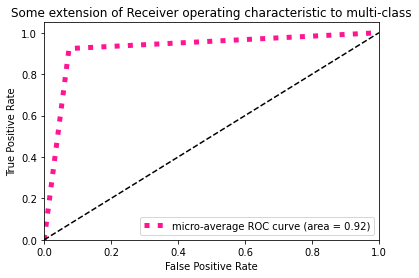

In [110]:
#naive Bayes

fpr_NB = dict()
tpr_NB = dict()
roc_auc_NB = dict()
for i in range(3):
    fpr_NB[i], tpr_NB[i], _ = roc_curve(Test_Y_binarise[:, i], predictions_NB_binarise[:, i])
    roc_auc_NB[i] = auc(fpr_NB[i], tpr_NB[i])

# Compute micro-average ROC curve and ROC area
fpr_NB["micro"], tpr_NB["micro"], _ = roc_curve(Test_Y_binarise.ravel(), predictions_NB_binarise.ravel())
roc_auc_NB["micro"] = auc(fpr_NB["micro"], tpr_NB["micro"])

# First aggregate all false positive rates
all_fpr_NB = np.unique(np.concatenate([fpr_NB[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr_NB = np.zeros_like(all_fpr_NB)
for i in range(3):
    mean_tpr_NB += interp(all_fpr_NB, fpr_NB[i], tpr_NB[i])

# Finally average it and compute AUC
mean_tpr_NB /= 3

# Plot all ROC curves
plt.figure()
plt.plot(fpr_NB["micro"], tpr_NB["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_NB["micro"]),
         color='deeppink', linestyle=':', linewidth=5)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine *(SVM)* Model

In [11]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
second=time.time()

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
historySVM = SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("Process time ", time.time()-second)

Process time  1493.6012251377106


In [12]:
modelEvaluation(predictions_SVM, Test_Y)


Accuracy on validation set: 0.8707

Classification report : 
               precision    recall  f1-score   support

        -1.0       0.66      0.43      0.52      1747
         0.0       0.41      0.01      0.01      1377
         1.0       0.88      0.99      0.93     16876

    accuracy                           0.87     20000
   macro avg       0.65      0.47      0.49     20000
weighted avg       0.83      0.87      0.83     20000


Confusion Matrix : 
 [[  754     2   991]
 [  178     7  1192]
 [  216     8 16652]]


In [13]:
asvm,bsvm,csvm,dsvm = precision_recall_fscore_support(Test_Y, predictions_SVM, average='macro')
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("Precision is: ",asvm)
print("Recall is: ",bsvm)
print("F-1 Score is: ",csvm)

SVM Accuracy Score ->  87.065
Precision is:  0.6508859610974215
Recall is:  0.47446908361578394
F-1 Score is:  0.48784631359236874


In [82]:
predictions_SVM_binarise = label_binarize(predictions_SVM, classes=[0, 1, 2])

C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


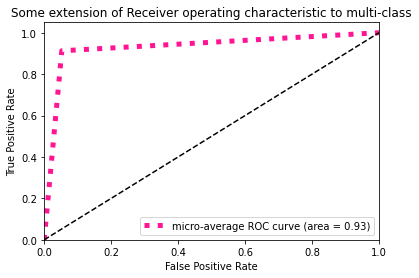

In [112]:
#SVM 

fpr_SVM = dict()
tpr_SVM = dict()
roc_auc_SVM = dict()
for i in range(3):
    fpr_SVM[i], tpr_SVM[i], _ = roc_curve(Test_Y_binarise[:, i], predictions_SVM_binarise[:, i])
    roc_auc_SVM[i] = auc(fpr_SVM[i], tpr_SVM[i])

# Compute micro-average ROC curve and ROC area
fpr_SVM["micro"], tpr_SVM["micro"], _ = roc_curve(Test_Y_binarise.ravel(), predictions_SVM_binarise.ravel())
roc_auc_SVM["micro"] = auc(fpr_SVM["micro"], tpr_SVM["micro"])

# First aggregate all false positive rates
all_fpr_SVM = np.unique(np.concatenate([fpr_SVM[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr_SVM = np.zeros_like(all_fpr_SVM)
for i in range(3):
    mean_tpr_SVM += interp(all_fpr_SVM, fpr_SVM[i], tpr_SVM[i])

# Finally average it and compute AUC
mean_tpr_SVM /= 3

# Plot all ROC curves
plt.figure()
plt.plot(fpr_SVM["micro"], tpr_SVM["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_SVM["micro"]),
         color='deeppink', linestyle=':', linewidth=5)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Decision Tree Model

In [93]:
#writing the data to a csv file

# lat_df.to_csv("CurrentUsedFile.csv")

In [14]:
third=time.time()
decTree = DecisionTreeClassifier()
decTree.fit(Train_X_Tfidf, Train_Y)
y_decTree_predicted = decTree.predict(Test_X_Tfidf)
#time 
print("Process time ", time.time()-third)

Process time  80.46823930740356


In [15]:
modelEvaluation(y_decTree_predicted, Test_Y)


Accuracy on validation set: 0.8250

Classification report : 
               precision    recall  f1-score   support

        -1.0       0.43      0.43      0.43      1747
         0.0       0.28      0.23      0.25      1377
         1.0       0.90      0.92      0.91     16876

    accuracy                           0.83     20000
   macro avg       0.54      0.52      0.53     20000
weighted avg       0.82      0.83      0.82     20000


Confusion Matrix : 
 [[  744   152   851]
 [  193   314   870]
 [  784   649 15443]]


In [80]:
y_decTree_predicted_binarise = label_binarize(y_decTree_predicted, classes=[0, 1, 2])

In [85]:
#decision tree

fpr_dectree = dict()
tpr_dectree = dict()
roc_auc_dectree = dict()
for i in range(3):
    fpr_dectree[i], tpr_dectree[i], _ = roc_curve(Test_Y_binarise[:, i], y_decTree_predicted_binarise[:, i])
    roc_auc_dectree[i] = auc(fpr_dectree[i], tpr_dectree[i])

# Compute micro-average ROC curve and ROC area
fpr_dectree["micro"], tpr_dectree["micro"], _ = roc_curve(Test_Y_binarise.ravel(), y_decTree_predicted_binarise.ravel())
roc_auc_dectree["micro"] = auc(fpr_dectree["micro"], tpr_dectree["micro"])

C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


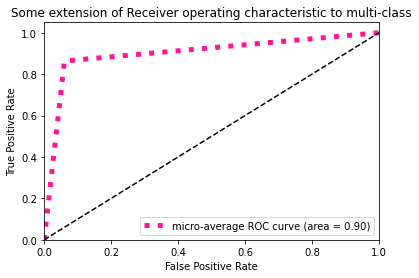

In [109]:
# First aggregate all false positive rates
all_fpr_dectree = np.unique(np.concatenate([fpr_dectree[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr_dectree = np.zeros_like(all_fpr_dectree)
for i in range(3):
    mean_tpr_dectree += interp(all_fpr_dectree, fpr_dectree[i], tpr_dectree[i])

# Finally average it and compute AUC
mean_tpr_dectree /= 3



# Plot all ROC curves
plt.figure()
plt.plot(fpr_dectree["micro"], tpr_dectree["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_dectree["micro"]),
         color='deeppink', linestyle=':', linewidth=5)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## plotting all 3 ROC together

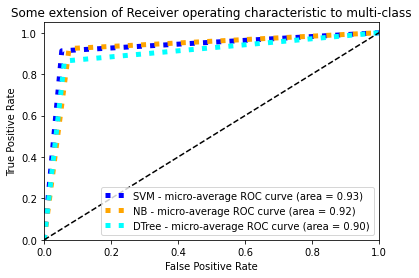

In [114]:
plt.figure()
plt.plot(fpr_SVM["micro"], tpr_SVM["micro"],
         label='SVM - micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_SVM["micro"]),
         color='blue', linestyle=':', linewidth=5)

plt.plot(fpr_NB["micro"], tpr_NB["micro"],
         label='NB - micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_NB["micro"]),
         color='orange', linestyle=':', linewidth=5)

plt.plot(fpr_dectree["micro"], tpr_dectree["micro"],
         label='DTree - micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_dectree["micro"]),
         color='cyan', linestyle=':', linewidth=5)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Step 9:

## *LSTM*

In [16]:
df = pd.read_csv("processedData.csv",nrows = 100000)
print(df.head(5))

   Unnamed: 0              id  \
0           0   AAP7PPBU72QFM   
1           1  A2E168DTVGE6SV   
2           2  A1ER5AYS3FQ9O3   
3           3  A1T17LMQABMBN5   
4           4  A3QHJ0FXK33OBE   

                                              review  rating  Sentiment  
0  This is the best novel I have read in 2 or 3 y...     5.0        1.0  
1  Pages and pages of introspection, in the style...     3.0        0.0  
2  This is the kind of novel to read when you hav...     5.0        1.0  
3  What gorgeous language! What an incredible wri...     5.0        1.0  
4  I was taken in by reviews that compared this b...     3.0        0.0  


In [17]:
import re

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['reviewFinal'] = df['review'].apply(clean_text)
df['reviewFinal'] = df['review'].str.replace('\d+', '')

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [19]:
MAX_NB_WORDS = 500000              #vary absed on size of dataset
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 15
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['reviewFinal'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58661 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df['reviewFinal'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 250)


In [21]:
Y = pd.get_dummies(df['Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (100000, 3)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(80000, 250) (80000, 3)
(20000, 250) (20000, 3)


In [23]:
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(15, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 940s 13ms/step - loss: 0.4646 - accuracy: 0.8508 - val_loss: 0.4036 - val_accuracy: 0.8630
Epoch 2/15
72000/72000 [==============================] - 868s 12ms/step - loss: 0.3679 - accuracy: 0.8745 - val_loss: 0.3684 - val_accuracy: 0.8734
Epoch 3/15
72000/72000 [==============================] - 877s 12ms/step - loss: 0.3335 - accuracy: 0.8822 - val_loss: 0.3690 - val_accuracy: 0.8735
Epoch 4/15
72000/72000 [==============================] - 867s 12ms/step - loss: 0.3067 - accuracy: 0.8908 - val_loss: 0.3734 - val_accuracy: 0.8770
Epoch 5/15
72000/72000 [==============================] - 868s 12ms/step - loss: 0.2860 - accuracy: 0.8967 - val_loss: 0.3700 - val_accuracy: 0.8714


In [24]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20000/20000 [==============================] - 44s 2ms/step
Test set
  Loss: 0.353
  Accuracy: 0.872


In [25]:
#making predictions using LSTM
y_hat = model.predict(X_test)


In [26]:
y_hat_class = model.predict_classes(X_test)

In [27]:
y_pred_list = y_hat_class.tolist()

In [28]:
y_test = []
for i in Y_test:
    y_test.append(np.argmax(i))

In [29]:
print(y_pred_list[:5])
print(y_test[:5])

[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]


In [30]:
modelEvaluation(y_pred_list,y_test)


Accuracy on validation set: 0.8718

Classification report : 
               precision    recall  f1-score   support

           0       0.56      0.65      0.60      1747
           1       0.32      0.10      0.15      1377
           2       0.92      0.96      0.94     16876

    accuracy                           0.87     20000
   macro avg       0.60      0.57      0.56     20000
weighted avg       0.85      0.87      0.86     20000


Confusion Matrix : 
 [[ 1134    77   536]
 [  373   135   869]
 [  503   206 16167]]


In [31]:
!pip install matplotlib

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


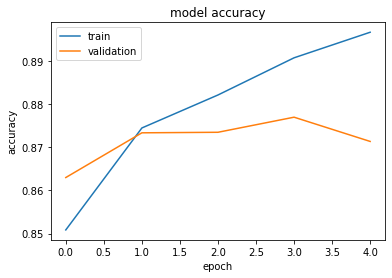

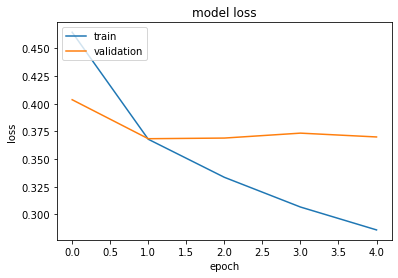

In [33]:
#plotting curves for LSTM

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Step 10:

## *Recurrent Neural Networks*

In [34]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))


Total 400000 word vectors in Glove 6B 100d.


In [35]:
EMBEDDING_DIM = 100

In [36]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


In [37]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline


In [38]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(3, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 100)          5866200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 6,027,603
Trainable params: 6,027,603
Non-trainable params: 0
_________________________________________________________________


In [39]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(X_train, Y_train, validation_split=0.1,epochs=15, batch_size=64,callbacks=[cp])

C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 790s 11ms/step - loss: 0.4174 - acc: 0.8568 - val_loss: 0.3651 - val_acc: 0.8751

Epoch 00001: val_acc improved from -inf to 0.87512, saving model to model_rnn.hdf5
Epoch 2/15
72000/72000 [==============================] - 790s 11ms/step - loss: 0.3217 - acc: 0.8861 - val_loss: 0.3363 - val_acc: 0.8808

Epoch 00002: val_acc improved from 0.87512 to 0.88075, saving model to model_rnn.hdf5
Epoch 3/15
72000/72000 [==============================] - 790s 11ms/step - loss: 0.2843 - acc: 0.8979 - val_loss: 0.3195 - val_acc: 0.8901

Epoch 00003: val_acc improved from 0.88075 to 0.89012, saving model to model_rnn.hdf5
Epoch 4/15
72000/72000 [==============================] - 791s 11ms/step - loss: 0.2586 - acc: 0.9067 - val_loss: 0.3195 - val_acc: 0.8886

Epoch 00004: val_acc did not improve from 0.89012
Epoch 5/15
72000/72000 [==============================] - 794s 11ms/step - loss: 0.235

In [40]:
#making predictions using RNN
y_hat = model.predict(X_test)


In [41]:
print(y_hat[:5])

y_pred_list = []

for i in y_hat:
    y_pred_list.append(np.argmax(i))
    
print(y_pred_list[:5])

[[1.61202269e-08 9.49052992e-05 9.99905109e-01]
 [5.95531083e-06 1.52459824e-02 9.84748065e-01]
 [1.11748406e-07 6.16432771e-06 9.99993682e-01]
 [1.91755788e-07 3.85143767e-06 9.99995947e-01]
 [6.68301325e-08 7.26460665e-03 9.92735386e-01]]
[2, 2, 2, 2, 2]


In [42]:
y_test = []
for i in Y_test:
    y_test.append(np.argmax(i))

In [43]:
print(y_pred_list[:5])
print(y_test[:5])

[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]


In [44]:
modelEvaluation(y_pred_list,y_test)


Accuracy on validation set: 0.8756

Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.62      0.66      1747
           1       0.33      0.36      0.35      1377
           2       0.94      0.94      0.94     16876

    accuracy                           0.88     20000
   macro avg       0.66      0.64      0.65     20000
weighted avg       0.88      0.88      0.88     20000


Confusion Matrix : 
 [[ 1089   326   332]
 [  209   502   666]
 [  270   685 15921]]


In [45]:
print("Accuracy is : ",accuracy_score(y_test, y_pred_list))

Accuracy is :  0.8756


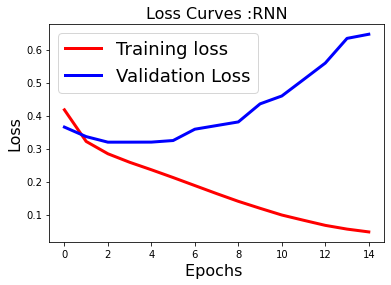

In [46]:

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

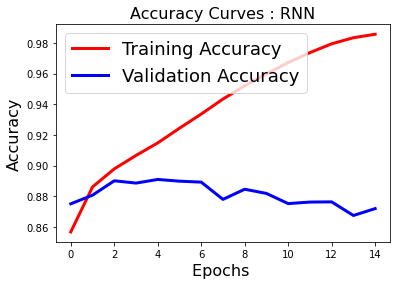

In [47]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

# Step 11:

## *CNN*

### Define CNN model

In [48]:
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding

In [49]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    print(model.summary())
    return model

In [ ]:
# label_names = ['Pos', 'Neg', 'Neu']
# y_train = data_train[label_names].values
# x_train = train_cnn_data
# y_tr = y_train

In [50]:
model = ConvNet(embedding_matrix, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 250, 100)     5866200     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 249, 200)     40200       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 248, 200)     60200       embedding_3[0][0]                
____________________________________________________________________________________________

### Train CNN

In [51]:
num_epochs = 15
batch_size = 64

In [52]:
hist = model.fit(X_train, Y_train, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)


Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 185s 3ms/step - loss: 0.2618 - acc: 0.9024 - val_loss: 0.2196 - val_acc: 0.9143
Epoch 2/15
72000/72000 [==============================] - 175s 2ms/step - loss: 0.2097 - acc: 0.9196 - val_loss: 0.2012 - val_acc: 0.9209
Epoch 3/15
72000/72000 [==============================] - 175s 2ms/step - loss: 0.1809 - acc: 0.9295 - val_loss: 0.2012 - val_acc: 0.9236
Epoch 4/15
72000/72000 [==============================] - 175s 2ms/step - loss: 0.1574 - acc: 0.9379 - val_loss: 0.2065 - val_acc: 0.9176
Epoch 5/15
72000/72000 [==============================] - 175s 2ms/step - loss: 0.1324 - acc: 0.9472 - val_loss: 0.2156 - val_acc: 0.9228
Epoch 6/15
72000/72000 [==============================] - 175s 2ms/step - loss: 0.1129 - acc: 0.9556 - val_loss: 0.2774 - val_acc: 0.9242
Epoch 7/15
72000/72000 [==============================] - 175s 2ms/step - loss: 0.0954 - acc: 0.9632 - val_loss: 0.2443 - v

In [53]:
predictions = model.predict(X_test)

In [54]:
print(predictions[:5])

y_pred_list = []

for i in predictions:
    y_pred_list.append(np.argmax(i))
    
print(y_pred_list[:5])

[[1.53808969e-06 6.76188138e-05 9.99926567e-01]
 [3.31541219e-06 4.32064378e-04 9.99511480e-01]
 [8.39450176e-11 1.14536325e-10 1.00000000e+00]
 [1.17434773e-08 6.79122625e-09 1.00000000e+00]
 [1.30038208e-03 5.60288550e-03 9.92873192e-01]]
[2, 2, 2, 2, 2]


In [55]:
y_test = []
for i in Y_test:
    y_test.append(np.argmax(i))

In [56]:
print(y_pred_list[:5])
print(y_test[:5])

[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]


In [57]:
modelEvaluation(y_pred_list,y_test)


Accuracy on validation set: 0.8781

Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.65      0.65      1747
           1       0.37      0.30      0.33      1377
           2       0.94      0.95      0.94     16876

    accuracy                           0.88     20000
   macro avg       0.65      0.63      0.64     20000
weighted avg       0.87      0.88      0.87     20000


Confusion Matrix : 
 [[ 1140   219   388]
 [  265   416   696]
 [  381   489 16006]]


In [58]:
print("Accuracy is : ",accuracy_score(y_test, y_pred_list))

Accuracy is :  0.8781


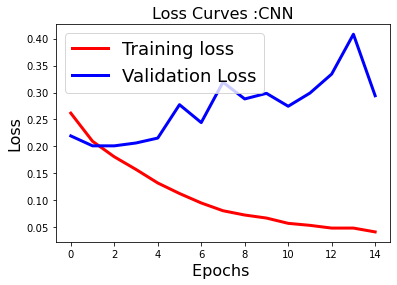

In [59]:

fig1 = plt.figure()
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

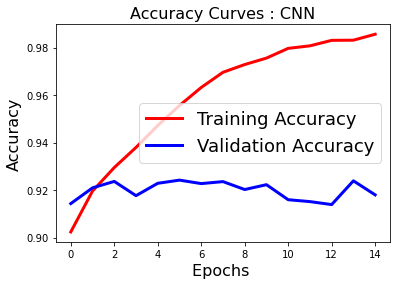

In [60]:
fig2=plt.figure()
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

# Step 12
# Recursive neural networks (RecNNs)

Define the model

In [61]:
from keras.layers import Dense, Dropout, Activation

In [62]:
def Build_Model(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=250, EMBEDDING_DIM=100):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256

    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector



    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [63]:
model = Build_Model(word_index,embeddings_index, 3)

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5866200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 249, 256)          51456     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 124, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 123, 256)          131328    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 256)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 60, 256)          

In [65]:
history = model.fit(X_train, Y_train,
                              validation_split=0.1,
                              epochs=15,
                              batch_size=64)

C:\Users\Harold\anaconda3\envs\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 285s 4ms/step - loss: 0.5107 - accuracy: 0.8428 - val_loss: 0.4747 - val_accuracy: 0.8436
Epoch 2/15
72000/72000 [==============================] - 282s 4ms/step - loss: 0.4298 - accuracy: 0.8562 - val_loss: 0.4381 - val_accuracy: 0.8624
Epoch 3/15
72000/72000 [==============================] - 282s 4ms/step - loss: 0.3985 - accuracy: 0.8685 - val_loss: 0.4364 - val_accuracy: 0.8629
Epoch 4/15
72000/72000 [==============================] - 282s 4ms/step - loss: 0.3780 - accuracy: 0.8761 - val_loss: 0.4223 - val_accuracy: 0.8676
Epoch 5/15
72000/72000 [==============================] - 283s 4ms/step - loss: 0.3629 - accuracy: 0.8800 - val_loss: 0.4220 - val_accuracy: 0.8674
Epoch 6/15
72000/72000 [==============================] - 282s 4ms/step - loss: 0.3496 - accuracy: 0.8847 - val_loss: 0.4115 - val_accuracy: 0.8698
Epoch 7/15
72000/72000 [==============================] - 283s 

In [66]:
predictions = model.predict(X_test)

In [67]:
print(predictions[:5])

y_pred_list = []

for i in predictions:
    y_pred_list.append(np.argmax(i))
    
print(y_pred_list[:5])

[[2.48492360e-02 3.48103046e-02 9.40340459e-01]
 [2.48492360e-02 3.48103046e-02 9.40340459e-01]
 [2.06992356e-03 1.11636175e-02 9.86766458e-01]
 [2.60349014e-04 2.31208699e-03 9.97427523e-01]
 [1.87349797e-03 1.02327960e-02 9.87893760e-01]]
[2, 2, 2, 2, 2]


In [68]:
y_test = []
for i in Y_test:
    y_test.append(np.argmax(i))

In [69]:
print(y_pred_list[:5])
print(y_test[:5])

[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]


In [70]:
modelEvaluation(y_pred_list,y_test)


Accuracy on validation set: 0.8535

Classification report : 
               precision    recall  f1-score   support

           0       0.49      0.59      0.54      1747
           1       0.21      0.07      0.11      1377
           2       0.91      0.94      0.93     16876

    accuracy                           0.85     20000
   macro avg       0.54      0.54      0.52     20000
weighted avg       0.83      0.85      0.84     20000


Confusion Matrix : 
 [[ 1031    93   623]
 [  401    97   879]
 [  658   276 15942]]


In [71]:
print("Accuracy is : ",accuracy_score(y_test, y_pred_list))

Accuracy is :  0.8535


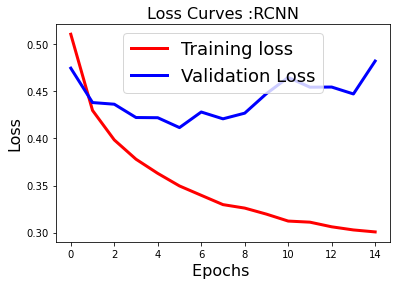

In [72]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RCNN',fontsize=16)
fig1.savefig('loss_rcnn.png')
plt.show()

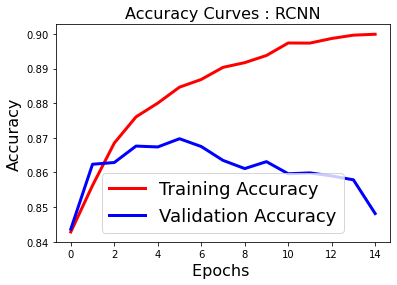

In [73]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RCNN',fontsize=16)
fig2.savefig('accuracy_rcnn.png')
plt.show()

# ROC Curves

In [74]:
%whos

Variable                          Type                      Data/Info
---------------------------------------------------------------------
AUC                               function                  <function roc_auc_score at 0x0000020581DFEE58>
Activation                        type                      <class 'keras.layers.core.Activation'>
BAD_SYMBOLS_RE                    Pattern                   re.compile('[^0-9a-z #+_]')
Bidirectional                     type                      <class 'keras.layers.wrappers.Bidirectional'>
Build_Model                       function                  <function Build_Model at 0x000002064BAF8D38>
Conv1D                            type                      <class 'keras.layers.convolutional.Conv1D'>
ConvNet                           function                  <function ConvNet at 0x00000205FD1E3318>
CountVectorizer                   type                      <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
DecisionTreeClassifier            